In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
from random import randint
from Detection.data_loader import *
import pickle

In [6]:
path = Path('/data/Datasets/EIPH_WSI/')

database = Database()
database.open(str(path/'EIPH.sqlite'))

True

In [49]:
size = 2048

In [7]:
files = []
lbl_bbox = []
size = 2048

getslides = """SELECT uid, filename FROM Slides"""
for currslide, filename in tqdm(database.execute(getslides).fetchall()):
    database.loadIntoMemory(currslide)

    check = True if 'erliner' in filename else False
    slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

    slide_path = path / slidetype / filename

    down_factor = 1

    classes = {3: 0, 4: 1, 5: 2, 6: 3, 7: 4}#{3: 1, 4: 2, 5: 3, 6: 4, 7: 5} #
    labels, bboxes = [], []
    for id, annotation in database.annotations.items():
        if annotation.labels[0].classId in classes:
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            label = classes[annotation.labels[0].classId]

            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(label)

    if len(bboxes) > 0:
        lbl_bbox.append([bboxes, labels])
        files.append(slide_path)

img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

  0%|          | 0/24 [00:00<?, ?it/s]

Loading DB into memory ...


  4%|▍         | 1/24 [00:00<00:07,  3.27it/s]

Loading DB into memory ...


  8%|▊         | 2/24 [00:01<00:13,  1.63it/s]

Loading DB into memory ...


 12%|█▎        | 3/24 [00:02<00:12,  1.73it/s]

Loading DB into memory ...


 21%|██        | 5/24 [00:02<00:07,  2.38it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 29%|██▉       | 7/24 [00:03<00:06,  2.79it/s]

Loading DB into memory ...


 38%|███▊      | 9/24 [00:03<00:04,  3.54it/s]

Loading DB into memory ...
Loading DB into memory ...


 46%|████▌     | 11/24 [00:03<00:02,  4.42it/s]

Loading DB into memory ...
Loading DB into memory ...


 50%|█████     | 12/24 [00:04<00:03,  3.97it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 71%|███████   | 17/24 [00:04<00:01,  4.78it/s]

Loading DB into memory ...
Loading DB into memory ...


 79%|███████▉  | 19/24 [00:05<00:00,  5.89it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 88%|████████▊ | 21/24 [00:05<00:00,  4.79it/s]

Loading DB into memory ...
Loading DB into memory ...


100%|██████████| 24/24 [00:06<00:00,  3.63it/s]

Loading DB into memory ...


In [64]:
def extract_histogram_and_score(slide: SlideContainer, xmin, ymin,  size, boxes, labels):
    w, h = size, size
    
    x = int(xmin)
    y = int(ymin)
    
    # select_boxes
    select_boxes = np.copy(boxes)
    select_boxes[:, [0, 2]] = select_boxes[:, [0, 2]] - x
    select_boxes[:, [1, 3]] = select_boxes[:, [1, 3]] - y

    bb_widths = (select_boxes[:, 2] - select_boxes[:, 0]) / 2
    bb_heights = (select_boxes[:, 3] - select_boxes[:, 1]) / 2

    ids = ((select_boxes[:, 0] + bb_widths) > 0) \
              & ((select_boxes[:, 1] + bb_heights) > 0) \
              & ((select_boxes[:, 2] - bb_widths) < w) \
              & ((select_boxes[:, 3] - bb_heights) < h)

    patch = np.array(slide.read_region(location=(x,y),
                                          level=0, size=(size, size)))[:, :, [2,1,0]]
    select_labels = np.copy(labels)[ids]
    score = np.mean(select_labels)
    
    histogram = np.concatenate((np.histogram(patch[:,:,0], bins=256)[0],
                                    np.histogram(patch[:,:,1], bins=256)[0],
                                    np.histogram(patch[:,:,2], bins=256)[0]))
    
    return patch, score, histogram

In [65]:
file = [f for f in files if "22_EIPH_575216 Turnbull blue" in str(f)][0]

slide = openslide.open_slide(str(file))

file

PosixPath('/data/Datasets/EIPH_WSI/Turnbull Blue/22_EIPH_575216 Turnbull blue.svs')

In [66]:
boxes_gt, labels_gt = get_y_func(file)

In [67]:
slide = openslide.open_slide(str(file))

In [96]:
x = 25000 #4500#
y = 15000 #7500#

In [103]:
patch, score, histogram = extract_histogram_and_score(slide, x,y, 1024, boxes_gt, labels_gt)

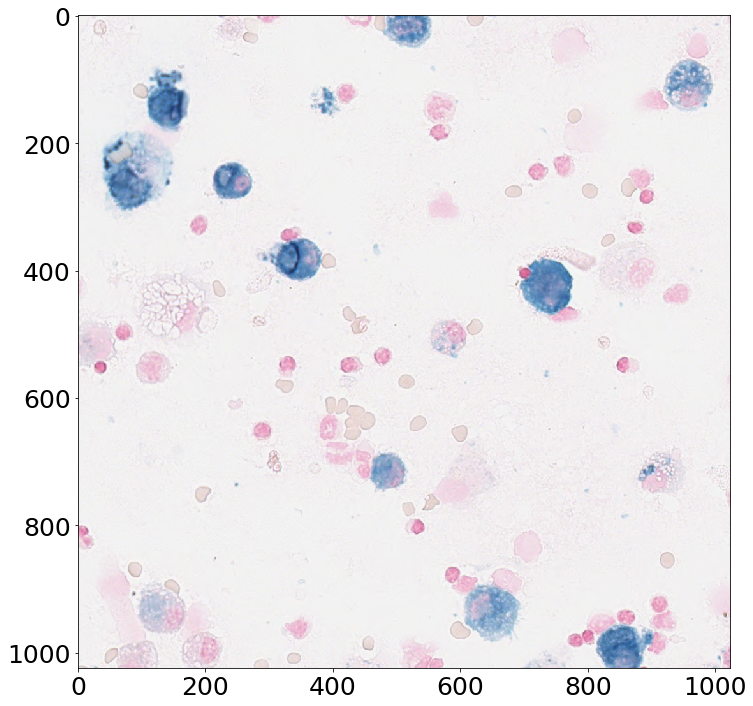

In [104]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(patch[:,:, [2,1,0]])


fig.savefig("HistogramPatch.svg", transparent=True)
fig.savefig("HistogramPatch.pdf", transparent=True)

In [99]:
score

1.295774647887324

In [72]:
histogram[:256]

array([   1,    0,    0,    1, ..., 7782, 3967, 1909, 1490])

/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


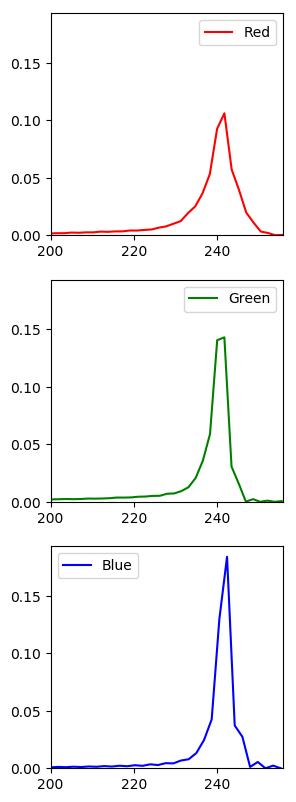

In [85]:
import seaborn as sns
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=3, ncols=1, figsize=(3, 10), sharey=True, dpi=100) #, figsize=(25,25)

#r
sns.distplot(patch[:,:, 0].flatten(), label="Red", ax=ax1, hist=False, color="r").set(xlim=(200, 256))

#g
sns.distplot(patch[:,:, 1].flatten(), label="Green", ax=ax2, hist=False, color="g").set(xlim=(200, 256))

#b
sns.distplot(patch[:,:, 2].flatten(), label="Blue", ax=ax3, hist=False, color="b").set(xlim=(200, 256))


plt.show()

/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


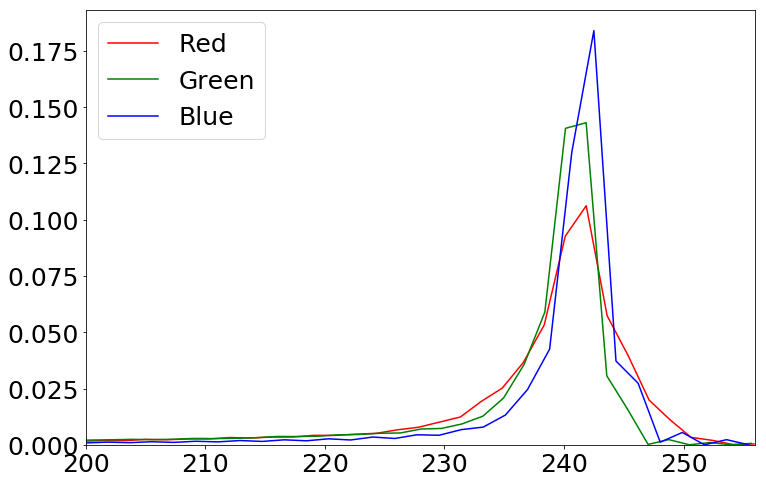

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))

plt.rcParams.update({'font.size': 25})

#r
sns.distplot(patch[:,:, 0].flatten(), label="Red", hist=False, color="r")

#g
sns.distplot(patch[:,:, 1].flatten(), label="Green", hist=False, color="g")

#b
ax=sns.distplot(patch[:,:, 2].flatten(), label="Blue", hist=False, color="b")

ax.set(xlim=(200, 256))

fig.savefig("Histogram.svg", transparent=True)
fig.savefig("Histogram.pdf", transparent=True)